# Lab 1 Solutions: NH Io Image Backplanes #

Use this image:
>>
PRODUCT_ID           = "LOR_0034785119_0X630_ENG"                             
START_TIME           = 2007-02-26T08:40:01.365                                
STOP_TIME            = 2007-02-26T08:40:01.368                                

Start by importing the usual modules and retrieving kernels from the NAIF site (with their subset tool). They provide a metakernel that's nice and labor saving. Image name and time are specified below in case you want to quickly switch to a different image.

In [13]:
imgname = '/Users/shane/Desktop/PTYS_551_code/PTYS551_2024/LAB1/assignment/lor_0034785119_0x630_eng.png'
imgtime = '2007-02-26T08:40:01.365'
metakernel = '/Users/shane/Desktop/PTYS_551_code/PTYS_551_kernels/nhsp/nh_v04_070226_070226.tm'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

spice.furnsh(metakernel)

First we retrieve some useful quantities about the LORRI field of view, the image time (in ET), shape of Io etc...

In [6]:
et  = spice.utc2et(imgtime)
with spice.no_found_check():
    [spcid, f]  = spice.bodn2c('NEW HORIZONS')      # Retrieve the ID code for the spacecraft
with spice.no_found_check():
    [instid,f] = spice.bodn2c('NH_LORRI')          # Retrieve the ID code for the instrument
[shape, frame, bsight, nbounds, bounds] = spice.getfov(instid, 20) # Find the corner points of the LORRI FOV
[num, radii] = spice.bodvrd('IO', 'RADII', 3)                      # Retrieve Io Radii to help conversion to lat/lon

ifov = 2.0 * np.arctan(np.abs(bounds[0,0]/bounds[0,2]))/1024.0     # Field of view of a single pixel

Next we search in a time window +/- two weeks from the image time for the closest approach to Io, Europa, Ganymede, and Callisto. We use the geometry finder function, ```gfdist``` for this. At the closest approach times, we retrieve the distances to each satellite with ```spkpos```.

In [7]:
utc1 = '2007-02-10T00:00:00'  # Closest approches were in Feb 2007 sometime. 
utc2 = '2007-03-10T00:00:00'
et1 = spice.utc2et(utc1) 
et2 = spice.utc2et(utc2)

cell = spice.cell_double(2)
spice.wninsd(et1,et2,cell)
ww = spice.cell_double(2000)

spice.gfdist('IO', 'LT+S', 'NEW_HORIZONS', 'ABSMIN', 0, 0, 10, 20, cell, ww)       # Find time of closest approach to Charon
[zz, et_io] = spice.wnfetd(ww,0)                                                     # There should only be one time range and it should have zero duration
spice.gfdist('EUROPA', 'LT+S', 'NEW_HORIZONS', 'ABSMIN', 0, 0, 10, 20, cell, ww)       # Find time of closest approach to Charon
[zz, et_europa] = spice.wnfetd(ww,0)                                                     # There should only be one time range and it should have zero duration
spice.gfdist('GANYMEDE', 'LT+S', 'NEW_HORIZONS', 'ABSMIN', 0, 0, 10, 20, cell, ww)       # Find time of closest approach to Charon
[zz, et_ganymede] = spice.wnfetd(ww,0)                                                     # There should only be one time range and it should have zero duration
spice.gfdist('CALLISTO', 'LT+S', 'NEW_HORIZONS', 'ABSMIN', 0, 0, 10, 20, cell, ww)       # Find time of closest approach to Charon
[zz, et_callisto] = spice.wnfetd(ww,0)                                                     # There should only be one time range and it should have zero duration

[starg, ltime] = spice.spkpos('IO', et_io, 'J2000', 'LT+S', 'NEW_HORIZONS')   
dist_io        = np.sqrt(np.sum(np.power(starg[0:3],2))) 
[starg, ltime] = spice.spkpos('EUROPA', et_europa, 'J2000', 'LT+S', 'NEW_HORIZONS')   
dist_europa        = np.sqrt(np.sum(np.power(starg[0:3],2))) 
[starg, ltime] = spice.spkpos('GANYMEDE', et_ganymede, 'J2000', 'LT+S', 'NEW_HORIZONS')   
dist_ganymede        = np.sqrt(np.sum(np.power(starg[0:3],2))) 
[starg, ltime] = spice.spkpos('CALLISTO', et_callisto, 'J2000', 'LT+S', 'NEW_HORIZONS')   
dist_callisto        = np.sqrt(np.sum(np.power(starg[0:3],2))) 

Print out the resuts in a formatted table. The resolution is the FOV of one pixel times the target distance.

In [8]:
print("{:<10} {:<22} {:<18} {:<18}".format('Body','Time','Distance (km)','Resolution (km/px)'))
print("{:<10} {:<22} {:<18} {:<18}".format('----','----','-------------','------------------'))
print("{:<10} {:<22} {:<18} {:<18}".format('IO',spice.et2utc(et_io,'ISOC',1),dist_io,dist_io*ifov))
print("{:<10} {:<22} {:<18} {:<18}".format('Europa',spice.et2utc(et_europa,'ISOC',1),dist_europa,dist_europa*ifov))
print("{:<10} {:<22} {:<18} {:<18}".format('Ganymede',spice.et2utc(et_ganymede,'ISOC',1),dist_ganymede,dist_ganymede*ifov))
print("{:<10} {:<22} {:<18} {:<18}".format('Callisto',spice.et2utc(et_callisto,'ISOC',1),dist_callisto,dist_callisto*ifov))

Body       Time                   Distance (km)      Resolution (km/px)
----       ----                   -------------      ------------------
IO         2007-02-28T21:57:14.0  2237668.1180239427 11.10682420889723 
Europa     2007-02-28T03:20:54.9  2963894.9744047443 14.711502652778654
Ganymede   2007-02-28T06:42:01.0  3015295.404225978  14.966632327142674
Callisto   2007-02-28T07:04:54.0  4154802.8346645823 20.622658175064394


In the second half of the problem we want to generate image backplanes of longitude, latitude and various illumination angles. The approach is to use the vectors that point to the LORRI FOV corners (retrieved above) and have 1024 evenly spaced values between them in x & y. The z coordinate is unchanged. This makes use a pinhole camera assumption for how the oprics work. In reality these cameras have small geometric distortions on the focal plane and pixels are not exactly evenly spaced. Reality is too inconvienient for this homeowrk problem though.

I also set up some arrays here that are full of NaNs to hold the final answers.

In [9]:
dx = np.abs((bounds[0,0]-bounds[2,0]) / 1024)
dy = np.abs((bounds[0,1]-bounds[2,1]) / 1024)

xp = np.arange(0.5,1023.51,1)*dx + bounds[1,0]
yp = np.arange(0.5,1023.51,1)*dy + bounds[1,1]
zp = bounds[0,2]

slon = np.zeros([1024,1024])
slat = np.zeros([1024,1024])
sinc = np.zeros([1024,1024])
semm = np.zeros([1024,1024])
spha = np.zeros([1024,1024])

slon[:,:] = np.nan
slat[:,:] = np.nan
sinc[:,:] = np.nan
semm[:,:] = np.nan
spha[:,:] = np.nan


Here's the actual guts of the calculation. I raster over all rows and columns and use the vector to that pixel to find an intercept point with Io. Most of the pixels don't intercept Io at all, but for the ones that do I calculate the longitude and latitude and illumination angles.

In [10]:
for i in range(0,len(xp)):
    for j in range(0,len(xp)):
        dvec=[xp[i],yp[j],zp]
        with spice.no_found_check():
            [spoint, trgepc, srfvec,f] = spice.sincpt('ELLIPSOID','IO',et,'IAU_IO','LT+S','NEW HORIZONS',frame,dvec)
            if f:
                [lon, lat, alt] = spice.recpgr('IO', spoint, radii[0], (radii[0]-radii[2])/radii[0])
                slon[i,j] = 360.0 - lon*180/np.pi
                if (slon[i,j] > 180):
                    slon[i,j] = slon[i,j] - 360.0
                slat[i,j] = lat*180/np.pi
                [trgepc, srfvec,phase, solar, emissn] = spice.ilumin('ELLIPSOID','IO', et, 'IAU_IO', 'LT+S', 'NEW HORIZONS', spoint)
                sinc[i,j] = solar
                semm[i,j] = emissn
                spha[i,j] = phase


Here we make a few plots to illustrate the results. Comparison to the image label file shows agreement with these values. We're looking close to the equator, with the north pole off to the right.  Note that I'm plotting the transpose of the quantities we calculated (necessary because of python's row-major aproach to arrays, or rather my not properly working with Python's approach... sigh...).

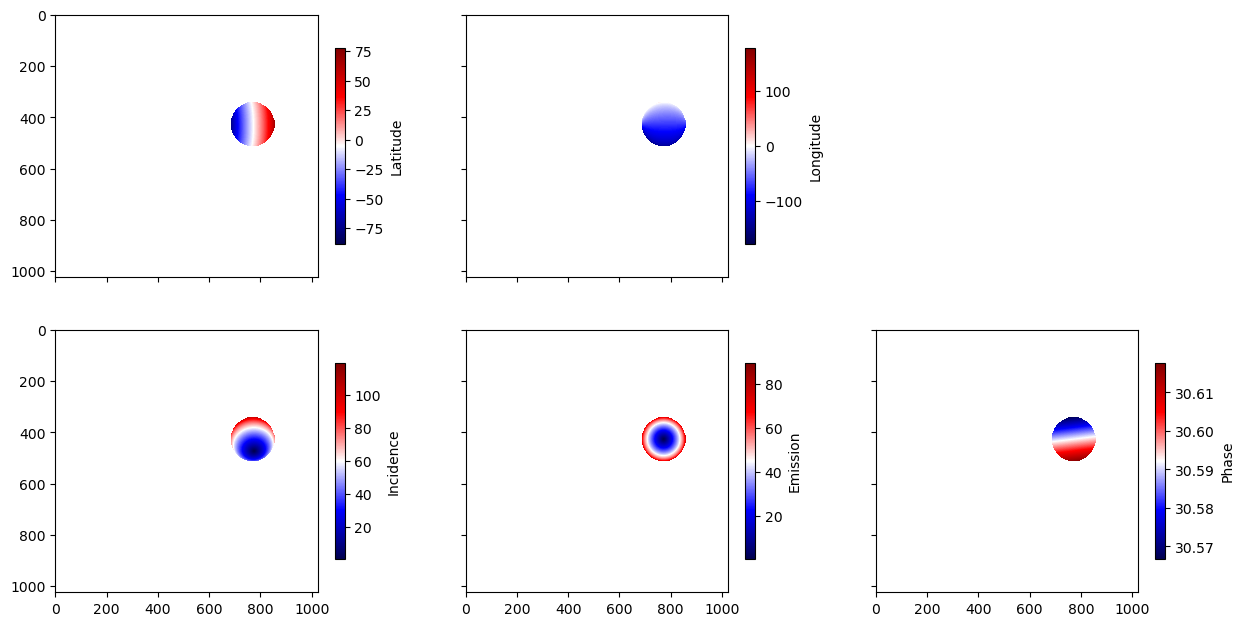

In [11]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,7.5), sharex=True, sharey=True)

axlat = ax1.imshow(slat.T, cmap='seismic') 
cbar = fig.colorbar(axlat, shrink=0.75, ax=ax1)
cbar.set_label('Latitude')

axlon = ax2.imshow(slon.T, cmap='seismic') 
cbar = fig.colorbar(axlon, shrink=0.75, ax=ax2)
cbar.set_label('Longitude')

ax3.axis('off')

axinc = ax4.imshow(sinc.T*180/np.pi, cmap='seismic')
cbar = fig.colorbar(axinc, shrink=0.75, ax=ax4)
cbar.set_label('Incidence')

axemm = ax5.imshow(semm.T*180/np.pi, cmap='seismic')
cbar = fig.colorbar(axemm, shrink=0.75, ax=ax5)
cbar.set_label('Emission')

axpha = ax6.imshow(spha.T*180/np.pi, cmap='seismic')
cbar = fig.colorbar(axpha, shrink=0.75, ax=ax6)
cbar.set_label('Phase')

Finally, let's check out a simulated view of Io (useful for planning camera exposure settings etc...).  We'll assume that Io scatters like a Lambert surface (probably roughly ok) and has a constant albedo (absolutely not true). In that case, brightness is just proportional to cosine of the incidence angle (but must be set to zero when incidence angle exceeds 90 degrees.

Here is the LORRI image compared to what we'd expect to see based on SPICE data alone.

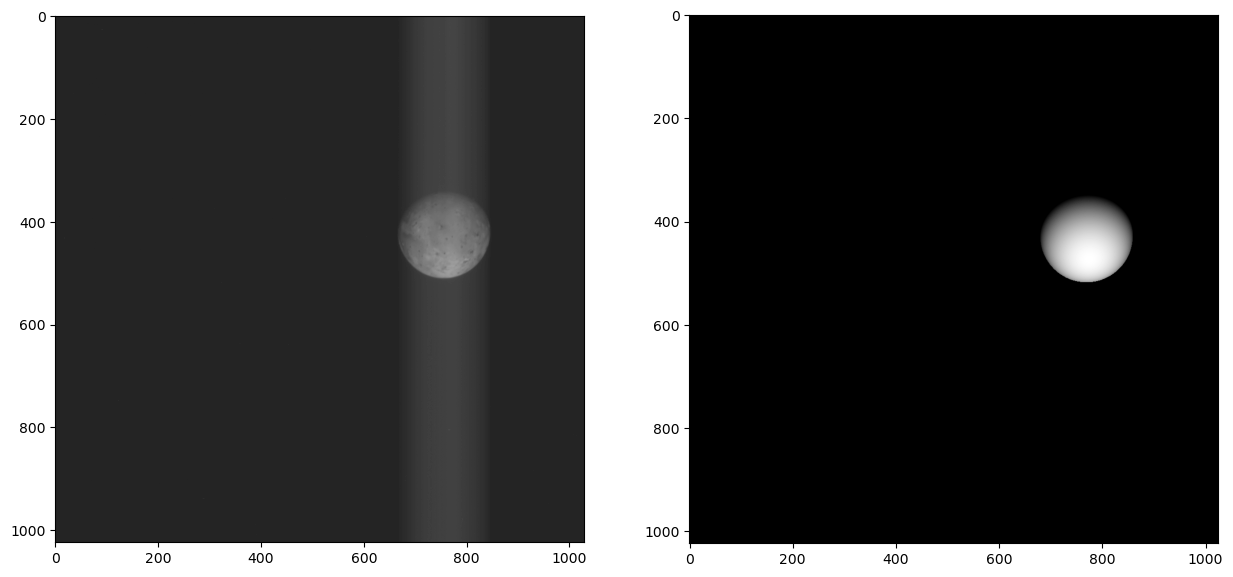

In [12]:
img     = plt.imread(imgname)
sbright = np.zeros([1024,1024])
sbright[sinc<np.pi/2.0] = np.cos(sinc[sinc<np.pi/2.0])

fig,(ax7,ax8) = plt.subplots(1,2,figsize=(15,10))
aximg         = ax7.imshow(      img,cmap='gray')
axbright      = ax8.imshow(sbright.T,cmap='gray')
